# Analyzing Bikeability and Bicycle Infrastructure in Moscow

In this project, I'm evaluating the bikeability of Moscow and analyzing the distribution and quality of bicycle infrastructure. The goal of the project is to provide insights into the city's bike-friendliness and identify areas where improvements can be made to encourage cycling as a sustainable mode of transportation.

## Libraries

In [44]:
import requests
import pandas as pd
import geopandas as gpd
import zipfile
import json
import matplotlib.pyplot as plt
import folium
from folium import plugins
#pd.set_option('display.max_rows', None)

## Municipalities

In [2]:
# data from https://gis-lab.info/qa/moscow-atd.html 

zip_file_path = '/Users/alina/Documents/geospatial_analysis/mo-shape.zip'
shapefile_name = 'mo.shp'

# extracting shapefile from zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

mos_municipal = gpd.read_file(shapefile_name)

EPSG:4326


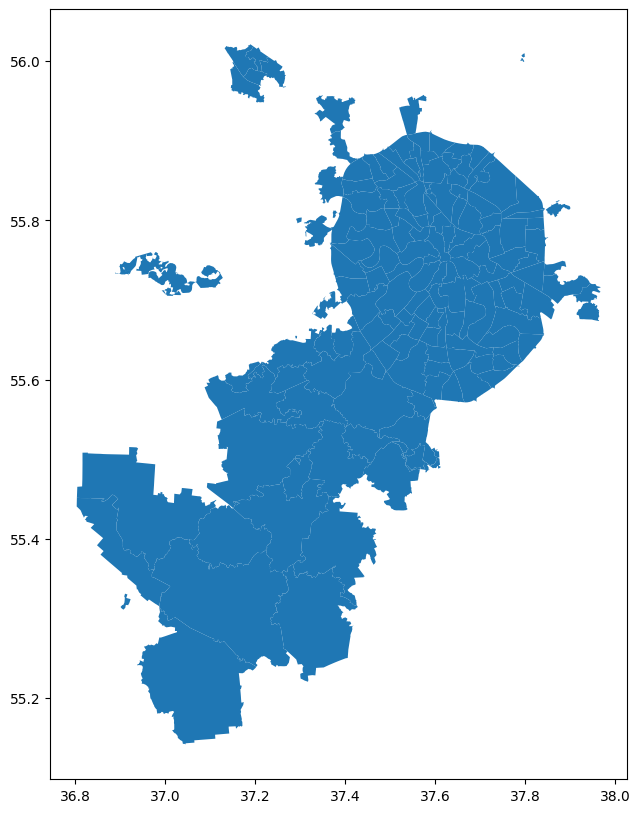

In [3]:
print(mos_municipal.crs)
ax = mos_municipal.plot(figsize=(10,10))

In [4]:
# defining extreme coordinates
total_bounds = mos_municipal.geometry.total_bounds
print("Westernmost point (min longitude):", total_bounds[0])
print("Southernmost point (min latitude):", total_bounds[1])
print("Easternmost point (max longitude):", total_bounds[2])
print("Northernmost point (max latitude):", total_bounds[3])

Westernmost point (min longitude): 36.8031012
Southernmost point (min latitude): 55.1421745
Easternmost point (max longitude): 37.9674277
Northernmost point (max latitude): 56.0212238


In [5]:
mos_municipal.head()

NAME     OKATO     OKTMO         NAME_AO  OKATO_AO  \
0         Киевский  45298555  45945000        Троицкий  45298000   
1   Филёвский Парк  45268595  45328000        Западный  45268000   
2  Новофёдоровское  45298567  45954000        Троицкий  45298000   
3        Роговское  45298575  45956000        Троицкий  45298000   
4     "Мосрентген"  45297568  45953000  Новомосковский  45297000   

        ABBREV_AO              TYPE_MO  \
0        Троицкий            Поселение   
1             ЗАО  Муниципальный округ   
2        Троицкий            Поселение   
3        Троицкий            Поселение   
4  Новомосковский            Поселение   

                                            geometry  
0  MULTIPOLYGON (((36.80310 55.44083, 36.80319 55...  
1  POLYGON ((37.42765 55.74821, 37.42849 55.74875...  
2  POLYGON ((36.80357 55.45162, 36.80451 55.46551...  
3  POLYGON ((36.93724 55.24139, 36.93726 55.24161...  
4  POLYGON ((37.43956 55.62731, 37.44018 55.63042...

## Bikeability data from mos.ru

### download using API

In [6]:
api_key = '4f894bb869173b4ff34769f21722f22d'

# for bikeability analysis datasets 897, 916, 918 are needed
# 897 - bike roads dataset
# 916 - bike parkings dataset
# 918 - bicycle rental dataset

In [7]:
def download_geojson_mosru(dataset_id, file, gdf, bbox=None):
    url = f'https://apidata.mos.ru/v1/datasets/{dataset_id}/features?api_key={api_key}'

    # check the number of rows
    # if nrows > 10000,  parameter bbox={bbox} should be added: https://apidata.mos.ru/help/index#/Features
    resp = requests.get(f'https://apidata.mos.ru/v1/datasets/{dataset_id}/count?api_key={api_key}')
    nrows = resp.json()
    if nrows > 10000:
        bbox = ['56.0212238, 36.8031012', '55.1421745, 37.9674277']
        url = f'https://apidata.mos.ru/v1/datasets/{dataset_id}/features?api_key={api_key}&bbox={bbox}'
    else:
        url = url
    response = requests.get(url)

    # check if the request was successful
    if response.status_code == 200:
        # decoding the response content as json
        data = response.json()
        # saving data to a file
        with open(f'{file}.geojson', 'w') as f:
            json.dump(data, f)   
        # loading the file into a geodataframe
        gdf = gpd.read_file(f'{file}.geojson')
        
        df = gdf['Attributes'].apply(pd.Series)
        gdf = gdf.drop(columns='Attributes').join(df)
        
        # dropping useless columns
        gdf = gdf.drop(columns=['DatasetId', 'VersionNumber', 'ReleaseNumber', 'RowId', 'is_deleted'])   
    else:
        print(f"Request failed with status code {response.status_code}")

    return gdf

In [8]:
bike_roads_gdf = download_geojson_mosru('897', 'bike_roads', 'bike_roads_gdf')

In [9]:
bike_parkings_gdf = download_geojson_mosru('916', 'bike_parkings', 'bike_parkings_gdf')

In [10]:
rental_gdf = download_geojson_mosru('918', 'rental', 'rental_gdf')

### plotting the map

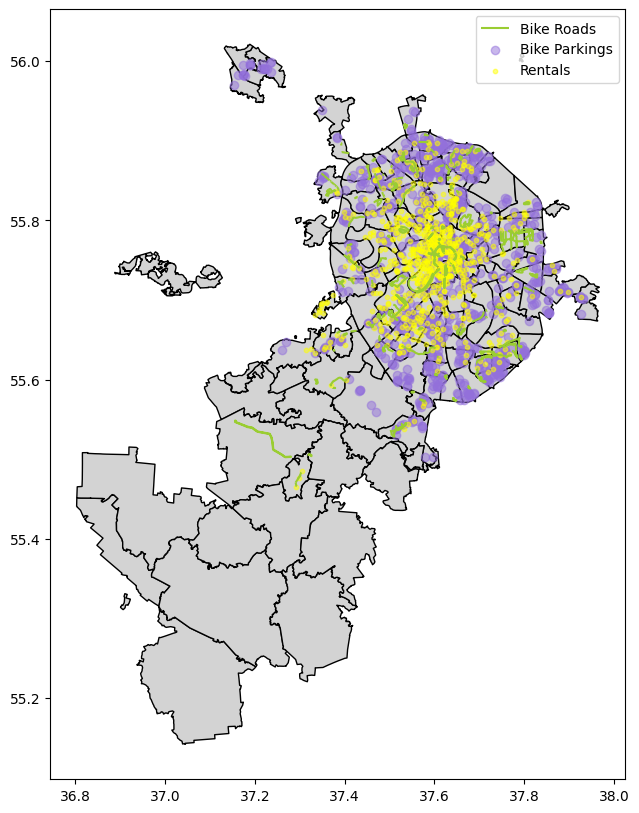

In [15]:
ax = mos_municipal.plot(figsize=(10,10), color='lightgrey', edgecolor='black')
bike_roads_gdf.plot(ax=ax, color='yellowgreen')
bike_parkings_gdf.plot(ax=ax, color='mediumpurple', alpha=0.5)
rental_gdf.plot(ax=ax, color='yellow', alpha=0.5, markersize=10)
ax.legend(['Bike Roads', 'Bike Parkings', 'Rentals'])

plt.show()

## Analysis

To my mind, to evaluate municipality bike infrastructure more trustworthy, lots of aspects should be taken into account, not only absence or presence of roads, parkings and rental stations.

In order to conduct a comprehensive analysis, I propose a metric called <b>Bikeability Index (BI)</b> that combines factors like population, the length and width of bike roads, rental stations and parkings capacity as well as bike roads, parkings, rentals number per municipality.

<b>The following steps were taken to conduct the above mentioned analysis:</b>
1. preprocessing of existing data, collecting all the necessary metrics
2. counting Bikeability Index (BI) of every municipality which will help assess the overall bike-friendliness of different areas in the city
3. identifying areas with high bikeability scores and those with low scores and giving suggestions on the factors contributing to the differences, indication of regions which have the most potential for improvement

### adding population data

In [11]:
# population by municipalities data is taken from this source:
# https://rosstat.gov.ru/storage/mediabank/chisl_MO_Site_01-01-2023.xlsx
# code for creating csv and csv itself in this repo

population_df = pd.read_csv('moscow_municipal_population_2023.csv')
population_by_mun = mos_municipal.join(population_df, lsuffix="DROP").filter(regex="^(?!.*DROP)")

In [12]:
population_by_mun.head()

geometry             NAME  \
0  MULTIPOLYGON (((36.80310 55.44083, 36.80319 55...         Киевский   
1  POLYGON ((37.42765 55.74821, 37.42849 55.74875...   Филёвский Парк   
2  POLYGON ((36.80357 55.45162, 36.80451 55.46551...  Новофёдоровское   
3  POLYGON ((36.93724 55.24139, 36.93726 55.24161...        Роговское   
4  POLYGON ((37.43956 55.62731, 37.44018 55.63042...     "Мосрентген"   

      OKATO     OKTMO         NAME_AO  OKATO_AO       ABBREV_AO  \
0  45298555  45945000        Троицкий  45298000        Троицкий   
1  45268595  45328000        Западный  45268000             ЗАО   
2  45298567  45954000        Троицкий  45298000        Троицкий   
3  45298575  45956000        Троицкий  45298000        Троицкий   
4  45297568  45953000  Новомосковский  45297000  Новомосковский   

               TYPE_MO  population  
0            Поселение       12072  
1  Муниципальный округ      113015  
2            Поселение       21725  
3            Поселение        6478  
4            Поселение       22029

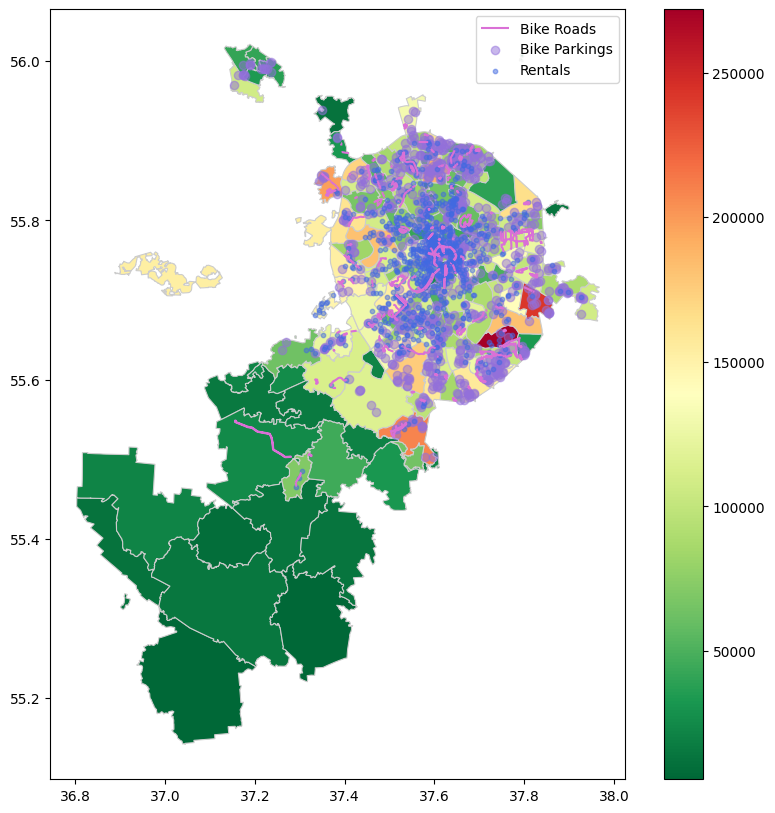

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
population_by_mun.plot(column='population', cmap='RdYlGn_r', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
bike_roads_gdf.plot(ax=ax, color='orchid')
bike_parkings_gdf.plot(ax=ax, color='mediumpurple', alpha=0.5)
rental_gdf.plot(ax=ax, color='royalblue', alpha=0.5, markersize=10)
ax.legend(['Bike Roads', 'Bike Parkings', 'Rentals'])
plt.show()

### counting bike road lengths

In [14]:
# in order to create a map, EPSG:4326 was used for all geodata
# to count road lengths accurately, we need to use a projected CRS instead of a geographic one

projected_crs = 'EPSG:32633'

# reprojecting the geometries to the projected CRS
bike_roads_reproj = bike_roads_gdf.to_crs(projected_crs)

# calculating the length of each MultiLineString in meters
bike_roads_gdf['Length'] = bike_roads_reproj['geometry'].length

In [15]:
bike_roads_gdf.head()

geometry  global_id  ID  \
0  MULTILINESTRING ((37.15713 55.54941, 37.15618 ...  660599284  11   
1  MULTILINESTRING ((37.55852 55.70953, 37.55928 ...  860145501  35   
2  MULTILINESTRING ((37.60051 55.75279, 37.60048 ...  660584272   8   
3  MULTILINESTRING ((37.61632 55.85286, 37.61439 ...  859835758   9   
4  MULTILINESTRING ((37.67449 55.59177, 37.67539 ...   59678455  11   

                                                Name  \
0  А/д Боровское шоссе – Киевское шоссе – д. Бота...   
1  Андреевская набережная, Природный заказник «Во...   
2                                  Арбатская площадь   
3                                    Березовая аллея   
4                             Бирюлевский дендропарк   

                                         PortionName  \
0  ТиНАО, посел. Первомайское, М-3 Украина- г.Тро...   
1                                                      
2                                  Площадь арбатская   
3                                                      
4                  Улица Липецкая, дом 28 (напротив)   

                                                Type  Width  \
0  [Велопешеходная дорожка с совмещенным движение...    1.8   
1       велосипедная дорожка двухстороннего движения    1.5   
2  [Велопешеходная дорожка с совмещенным движение...    1.2   
3       велосипедная дорожка одностороннего движения    1.0   
4     Велопешеходная дорожка с совмещенным движением    1.5   

                                            Location  \
0  ТиНАО, посел. Первомайское, М-3 Украина- г.Тро...   
1                          улица Крымский Вал, дом 9   
2                                  Арбатская площадь   
3  от Олонецкой улицы дом 15Б до Березовой аллеи ...   
4                в границах Бирюлевского дендропарка   

                                         OperOrgName ObjectOperOrgPhone  \
0                           ГБУ Автомобильные дороги    (495) 940-06-94   
1  Государственное автономное учреждение культуры...    (495) 995-00-20   
2                           ГБУ Автомобильные дороги    (495) 940-06-94   
3  Государственное бюджетное учреждение города Мо...    (495) 708-44-69   
4                                    ГПБУ Мосприрода    (499) 739-27-05   

              DepartmentalAffiliation        Length  
0                                 NaN  21600.650270  
1  Департамент культуры города Москвы   1340.337033  
2                                 NaN    370.159986  
3                                 NaN    854.299723  
4                                 NaN   1008.086507

### roads, parkings and rentals number per municipality

To calculate the number per municipality, I will work with the data differently (for the sake of interest).

1. 'bike_roads_gdf' doesn't contain a column with the municipality which the road is located in, however, 'moscow_municipal' and 'bike_roads_gdf' contain geographical informartion. So the number of bike roads per municipality is counted by performing spatial join.

2. 'bike_parkings_gdf' and 'rental_gdf' contain a column with the municipality which the road is located in, however, the names of the municipalities contain words like "район" and "поселение" so we can drop this part of string using regular expressions.

In [17]:
# spatial joins to detect municipalities where roads are located
bike_roads_with_municipality = gpd.sjoin(bike_roads_gdf, population_by_mun, predicate='within')

# count the number of each item per municipality and covert series to df
roads_count_df = bike_roads_with_municipality['NAME'].value_counts().reset_index()

# rename columns to perform merge on name
roads_count_df.columns=['NAME', 'bike_roads_count']
pop_count_by_mun = population_by_mun.merge(roads_count_df, on='NAME', how='left')

# fill NaN values with 0 (NaN means there are no bike roads in that district)
pop_count_by_mun['bike_roads_count'] = pop_count_by_mun['bike_roads_count'].fillna(0)

In [18]:
# counting the number of parkings and rental stations
# bringing the names of municipalities to the general form with regular expressions

bike_parkings_gdf['District'] = bike_parkings_gdf['District'].replace(['поселение ', ' поселение', 'район ', ' район'], '', regex=True)
rental_gdf['District'] = rental_gdf['District'].replace(['поселение ', ' поселение', 'район ', ' район'], '', regex=True)

In [19]:
# adding number of parkings per municipality to the existing df with districts and counts of roads
parkings_count_df = bike_parkings_gdf.District.value_counts().reset_index()
parkings_count_df.columns = ['NAME', 'parkings_count']
pop_count_by_mun = pd.merge(pop_count_by_mun, parkings_count_df, on='NAME', how='left')

# fill NaN values with 0
pop_count_by_mun['parkings_count'] = pop_count_by_mun['parkings_count'].fillna(0)

In [20]:
# adding number of rental stations per municipality to the existing df with counts of roads and parkings
rental_count_df = rental_gdf.District.value_counts().reset_index()
rental_count_df.columns = ['NAME', 'rental_count']
pop_count_by_mun = pd.merge(pop_count_by_mun, rental_count_df, on='NAME', how='left')

# fill NaN values with 0
pop_count_by_mun['rental_count'] = pop_count_by_mun['rental_count'].fillna(0)

In [21]:
pop_count_by_mun.head()

geometry             NAME  \
0  MULTIPOLYGON (((36.80310 55.44083, 36.80319 55...         Киевский   
1  POLYGON ((37.42765 55.74821, 37.42849 55.74875...   Филёвский Парк   
2  POLYGON ((36.80357 55.45162, 36.80451 55.46551...  Новофёдоровское   
3  POLYGON ((36.93724 55.24139, 36.93726 55.24161...        Роговское   
4  POLYGON ((37.43956 55.62731, 37.44018 55.63042...     "Мосрентген"   

      OKATO     OKTMO         NAME_AO  OKATO_AO       ABBREV_AO  \
0  45298555  45945000        Троицкий  45298000        Троицкий   
1  45268595  45328000        Западный  45268000             ЗАО   
2  45298567  45954000        Троицкий  45298000        Троицкий   
3  45298575  45956000        Троицкий  45298000        Троицкий   
4  45297568  45953000  Новомосковский  45297000  Новомосковский   

               TYPE_MO  population  bike_roads_count  parkings_count  \
0            Поселение       12072               0.0             0.0   
1  Муниципальный округ      113015               1.0             1.0   
2            Поселение       21725               0.0             0.0   
3            Поселение        6478               0.0             0.0   
4            Поселение       22029               0.0             0.0   

   rental_count  
0           0.0  
1           8.0  
2           0.0  
3           0.0  
4           0.0

### counting Bikeability Index (BI)

In [22]:
# population, road length, road width, rental stations and parkings capacity, counts (bike roads, parkings, rentals) normalization
# normalizing everything to values between 0 and 1

# normalize population
max_population = pop_count_by_mun['population'].max()
pop_count_by_mun['population_normalized'] = pop_count_by_mun['population'] / max_population

# normalize road lenghs & widths
max_length = bike_roads_gdf['Length'].max()
max_width = bike_roads_gdf['Width'].max()
bike_roads_gdf['length_normalized'] = bike_roads_gdf['Length'] / max_length
bike_roads_gdf['width_normalized'] = bike_roads_gdf['Width'] / max_width

# normalize parkings capacity and rental station capacity
max_park_cap = bike_parkings_gdf['Capacity'].max()
bike_parkings_gdf['capacity_normalized'] = bike_parkings_gdf['Capacity'] / max_park_cap
max_rental_cap = rental_gdf['StationCapacity'].max()
rental_gdf['capacity_normalized'] = rental_gdf['StationCapacity'] / max_rental_cap

# normalize counts (bike roads, parkings, rentals)
max_roads_count = pop_count_by_mun['bike_roads_count'].max()
max_park_count = pop_count_by_mun['parkings_count'].max()
max_rent_count = pop_count_by_mun['rental_count'].max()
pop_count_by_mun['roads_count_normalized'] = pop_count_by_mun['bike_roads_count'] / max_roads_count
pop_count_by_mun['park_count_normalized'] = pop_count_by_mun['parkings_count'] / max_park_count
pop_count_by_mun['rent_count_normalized'] = pop_count_by_mun['rental_count'] / max_rent_count

In [23]:
# weights for factors influencing bikeability in municipality
# weights are assigned empirically
weight_bike_roads = 0.3
weight_length = 0.1
weight_width = 0.1
weight_bike_parkings = 0.3
weight_parkings_capacity = 0.1
weight_bike_rentals = 0.3
weight_rental_capacity = 0.1
weight_population = 0.1

In [24]:
# constants to avoid zero Bikeability Index
CONSTANT = 0.01

# Calculate Bikeability Index
pop_count_by_mun['Bikeability_Index'] = ((weight_bike_roads * (pop_count_by_mun['roads_count_normalized'] + CONSTANT)) 
                                         + (weight_length * (bike_roads_gdf['length_normalized'] + CONSTANT))
                                         + (weight_width * (bike_roads_gdf['width_normalized'] + CONSTANT)) 
                                         + (weight_bike_parkings * (pop_count_by_mun['park_count_normalized'] + CONSTANT)) 
                                         + (weight_parkings_capacity * (bike_parkings_gdf['capacity_normalized'] + CONSTANT))
                                         + (weight_bike_rentals * (pop_count_by_mun['rent_count_normalized'] + CONSTANT)) 
                                         + (weight_rental_capacity * (rental_gdf['capacity_normalized'] + CONSTANT))) / (weight_population * pop_count_by_mun['population_normalized'])


In [25]:
pop_count_by_mun.sort_values(by='Bikeability_Index')

geometry                 NAME  \
123  POLYGON ((37.69291 55.64383, 37.69384 55.64462...              Марьино   
58   POLYGON ((37.48833 55.60827, 37.48906 55.60927...              Ясенево   
127  POLYGON ((37.71313 55.65852, 37.71455 55.65957...              Люблино   
145  MULTIPOLYGON (((37.29050 55.80199, 37.29542 55...              Кунцево   
57   POLYGON ((37.47495 55.53349, 37.47516 55.53411...         Южное Бутово   
..                                                 ...                  ...   
6    POLYGON ((37.05274 55.39473, 37.05483 55.39678...  Михайлово-Ярцевское   
33   POLYGON ((37.33132 55.93387, 37.33496 55.93538...       Молжаниновский   
0    MULTIPOLYGON (((36.80310 55.44083, 36.80319 55...             Киевский   
3    POLYGON ((36.93724 55.24139, 36.93726 55.24161...            Роговское   
20   POLYGON ((37.23363 55.29922, 37.23491 55.30230...           Клёновское   

        OKATO     OKTMO        NAME_AO  OKATO_AO ABBREV_AO  \
123  45290572  45390000  Юго-Восточный  45290000      ЮВАО   
58   45293598  45910000   Юго-Западный  45293000      ЮЗАО   
127  45290568  45389000  Юго-Восточный  45290000      ЮВАО   
145  45268562  45320000       Западный  45268000       ЗАО   
57   45293594  45909000   Юго-Западный  45293000      ЮЗАО   
..        ...       ...            ...       ...       ...   
6    45298564  45951000       Троицкий  45298000  Троицкий   
33   45277584  45343000       Северный  45277000       САО   
0    45298555  45945000       Троицкий  45298000  Троицкий   
3    45298575  45956000       Троицкий  45298000  Троицкий   
20   45298558  45946000       Троицкий  45298000  Троицкий   

                 TYPE_MO  population  bike_roads_count  parkings_count  \
123  Муниципальный округ      271915               1.0             2.0   
58   Муниципальный округ      175253               0.0            13.0   
127  Муниципальный округ      181447               0.0             5.0   
145  Муниципальный округ      153316               0.0             2.0   
57   Муниципальный округ      208783               1.0            14.0   
..                   ...         ...               ...             ...   
6              Поселение        9287               0.0             0.0   
33   Муниципальный округ       12487               0.0             1.0   
0              Поселение       12072               0.0             0.0   
3              Поселение        6478               0.0             0.0   
20             Поселение        5609               0.0             0.0   

     rental_count  population_normalized  roads_count_normalized  \
123           7.0               1.000000                     0.1   
58            0.0               0.644514                     0.0   
127           4.0               0.667293                     0.0   
145           4.0               0.563838                     0.0   
57            3.0               0.767825                     0.1   
..            ...                    ...                     ...   
6             0.0               0.034154                     0.0   
33            0.0               0.045922                     0.0   
0             0.0               0.044396                     0.0   
3             0.0               0.023824                     0.0   
20            0.0               0.020628                     0.0   

     park_count_normalized  rent_count_normalized  Bikeability_Index  
123                 0.0250               0.159091           2.097882  
58                  0.1625               0.000000           2.451550  
127                 0.0625               0.090909           2.507527  
145                 0.0250               0.090909           2.835165  
57                  0.1750               0.068182           2.982867  
..                     ...                    ...                ...  
6                   0.0000               0.000000          33.667852  
33                  0.0125               0.000000          44.650401  
0      

The above presented table shows all Moscow municipalities starting from the ones with the lowest bikeability indexes. That means these regions need to be given special attention when planning the construction of bicycle infrastructure.

In [36]:
# using the nsmallest function to get the indices of the 10 smallest values in the 'Bikeability_Index' column
# using the loc indexer to select those rows from the original dataframe pop_count_by_mun
municipalities_to_improve = pop_count_by_mun.loc[pop_count_by_mun['Bikeability_Index'].nsmallest(10).index]

In [38]:
municipalities_to_improve_list = list(municipalities_to_improve['NAME'])

Below you can see the list of top 10 municipalities, the bike infrastructure of which should be improved first and foremost. Despite the fact that there are some bike lanes, parking lots and rental stations in these regions, nevertheless, the number of people living in the regions is very large so the creation of more infrastructure is a necessity.

In [39]:
municipalities_to_improve_list

['Марьино',
 'Ясенево',
 'Люблино',
 'Кунцево',
 'Южное Бутово',
 'Выхино-Жулебино',
 'Гольяново',
 'Очаково-Матвеевское',
 'Крюково',
 'Северное Тушино']

### BI visualisation

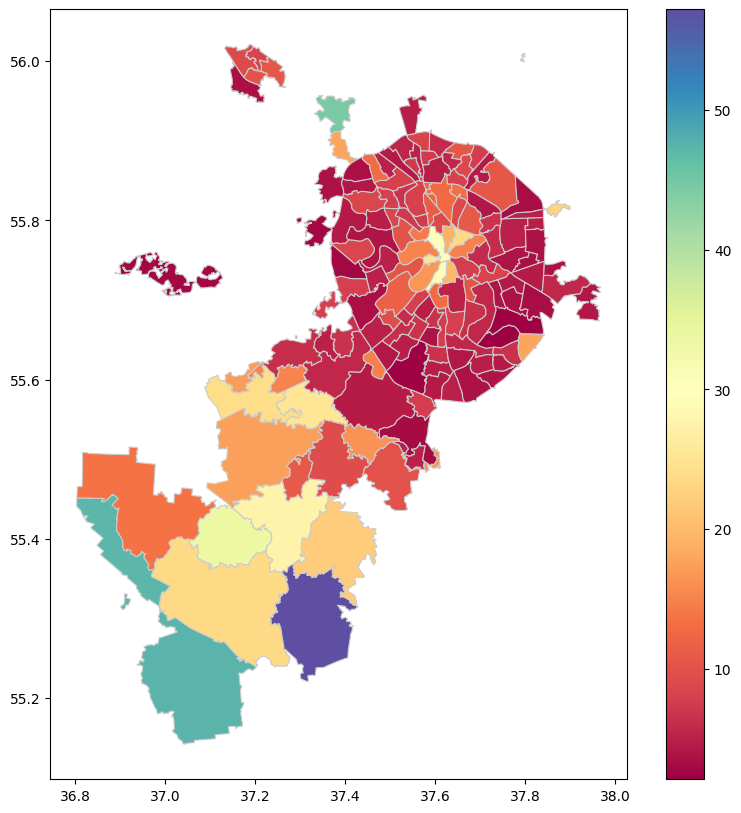

In [43]:
# Bikeability Index visualisation
# the lower the index (i.e. the more red the region is), the less sufficient its bike infrastructure is
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
pop_count_by_mun.plot(column='Bikeability_Index', cmap='Spectral', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.show()

## Interactive maps

In [148]:
map_center = [55.7558, 37.6176]  # Moscow coordinates

# creating a base map with zoomout limitations
m = folium.Map(location=map_center, zoom_start=10)
m.options['minZoom'] = 8

# creating a FeatureGroup for each marker category
bike_parkings_group = folium.FeatureGroup(name='Bike Parkings')
rentals_group = folium.FeatureGroup(name='Rentals')
bike_roads_group = folium.FeatureGroup(name='Bike Roads')

# creating and adding Choropleth layer to show population
choropleth_layer = folium.Choropleth(
    geo_data=population_by_mun.__geo_interface__,
    data=population_by_mun,
    columns=['NAME', 'population'],
    key_on='feature.properties.NAME',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='Population',
    name='population by municipality layer'
)

choropleth_layer.add_to(m)

# creating MarkerClusters for roads, parkings and rentals
bike_parkings_cluster = plugins.MarkerCluster(control=False, options={'maxClusterRadius': 30})
rentals_cluster = plugins.MarkerCluster(control=False, options={'maxClusterRadius': 30})
bike_roads_cluster = plugins.MarkerCluster(control=False, options={'maxClusterRadius': 30})

# adding bike parkings to MarkerCluster
for idx, row in bike_parkings_gdf.iterrows():
    folium.Marker([row['geometry'].y, row['geometry'].x],
                  icon=folium.Icon(color='green'),
                  popup=f"Name: {row['Name']}<br>Address: {row['Address']}").add_to(bike_parkings_cluster)
bike_parkings_group.add_child(bike_parkings_cluster)

# adding rentals to MarkerCluster
for idx, row in rental_gdf.iterrows():
    folium.Marker([row['geometry'].y, row['geometry'].x],
                  icon=folium.Icon(color='orange'),
                  popup=f"Name: {row['Name']}<br>Address: {row['Location']}").add_to(rentals_cluster)
rentals_group.add_child(rentals_cluster)

# adding bike roads to MarkerCluster
# creating a list to store bike road features
# this step is made bc roads consist of 2 objects: lines and markers with name and address
bike_road_features = []

# iterate over bike roads and add them to the list and the bike roads group
for idx, row in bike_roads_gdf.iterrows():
    road_feature = folium.GeoJson(row['geometry'], style_function=lambda x: {'color': 'yellowgreen'})
    bike_road_features.append(road_feature)
    folium.Marker([row['geometry'].centroid.y, row['geometry'].centroid.x],
                  icon=folium.Icon(color='red'),
                  popup=f"Name: {row['Name']}<br>Address: {row['Location']}").add_to(bike_roads_cluster)
    
bike_roads_group.add_child(bike_roads_cluster)

# add all bike road features to the bike roads group
for road_feature in bike_road_features:
    bike_roads_group.add_child(road_feature)

# add different tile views
folium.TileLayer('OpenStreetMap').add_to(m)
folium.TileLayer('CartoDB Positron').add_to(m)
folium.TileLayer(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                 attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community',
                 name='satellite world map').add_to(m)

# add FeatureGroups to the map
bike_parkings_group.add_to(m)
rentals_group.add_to(m)
bike_roads_group.add_to(m)

# creating a custom LayerControl
# now a user can choose tiles and switch on/off population, markers with roads, parkings and rentals
layer_control = folium.LayerControl(position='bottomleft', collapsed=False)
layer_control.add_to(m)

# creating a mini map
minimap = plugins.MiniMap()
m.add_child(minimap)

# save the map as an HTML file with this line below
m.save('map_bike_infrastructure_with_pop.html') 

In [149]:
m